## Data exploration

Explore the training data, focusing on the distribution of the 'label' column and determine to use AUC-PR,Precision,Recall,F1 Score as metrics

In [1]:
## Data exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, balanced_accuracy_score, recall_score, f1_score, confusion_matrix,precision_recall_curve,auc
from sklearn.preprocessing import StandardScaler
import warnings
import tensorflow as tf
import torch
import os
import locale
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv('train_set.csv')
test_data = pd.read_csv('test_set.csv')

# Display basic info
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
train_data.head()

Training data shape: (208691, 13)
Testing data shape: (52173, 13)


,user_id,merchant_id,label,age_range,gender,total_logs,unique_item_ids,categories,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times
0,63912,542,0,6.0,0.0,8,3,1,2,7,0,1,0
1,199431,3844,0,3.0,1.0,12,3,3,1,11,0,1,0
2,37919,3335,0,4.0,0.0,4,1,1,1,3,0,1,0
3,212162,120,0,5.0,0.0,4,1,1,1,3,0,1,0
4,380333,1203,0,5.0,0.0,19,8,5,2,18,0,1,0


## Split Sets and Feature Scaling

In [4]:
# Split data into features and target
X = train_data.drop('label', axis=1)
y = train_data['label']

# Check if test data contains 'label' column and remove it if it does
if 'label' in test_data.columns:
    X_test = test_data.drop('label', axis=1)
else:
    X_test = test_data

# Now split into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training set shape: (166952, 12)
Validation set shape: (41739, 12)
Test set shape: (52173, 12)


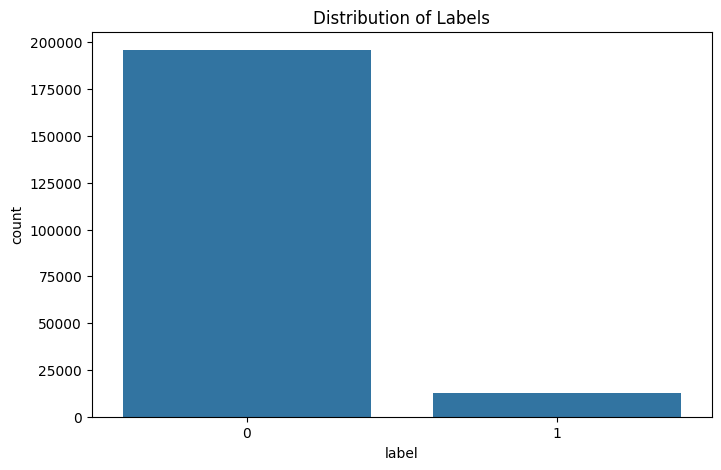

Positive examples: 12805
Negative examples: 195886
Positive ratio: 6.14%


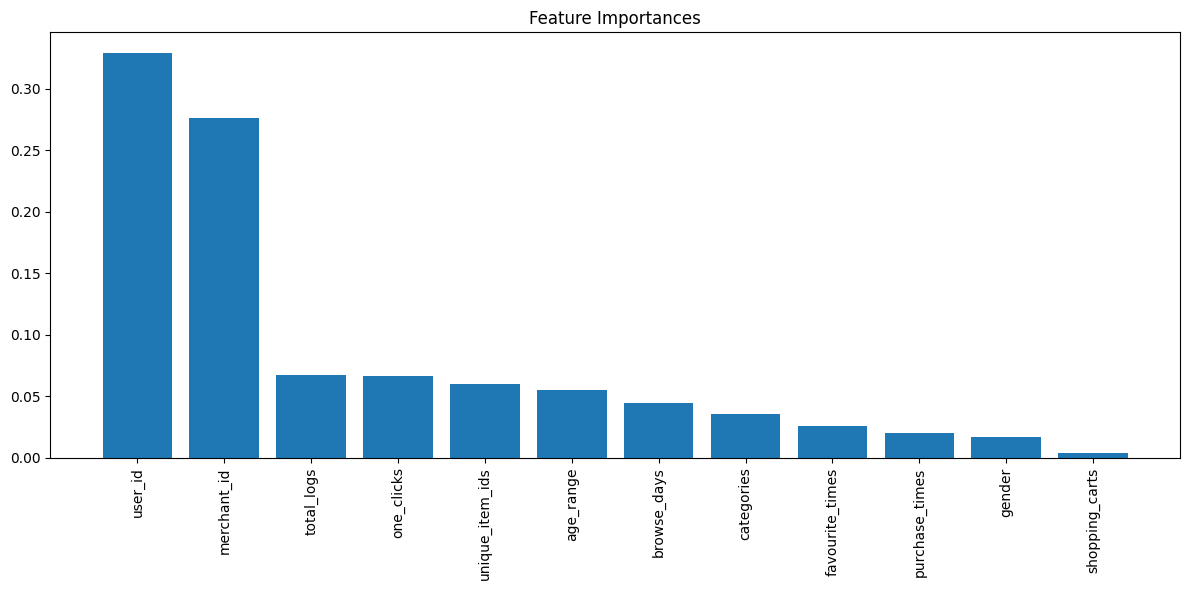


Evaluation metrics to be used:
1. AUC-PR: More sensitive to unbalanced small portion of positive cases
2. Accuracy: Proportion of correct predictions
3. Precision: Proportion of positive identifications that were actually correct
4. Recall: Proportion of actual positives that were identified correctly
5. F1-score: Harmonic mean of precision and recall


In [5]:
# Explore the label distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_data)
plt.title('Distribution of Labels')
plt.show()

print(f"Positive examples: {sum(train_data['label'] == 1)}")
print(f"Negative examples: {sum(train_data['label'] == 0)}")
print(f"Positive ratio: {sum(train_data['label'] == 1) / len(train_data):.2%}")

# --- Feature Importance Visualization ---
# Fit a RandomForestClassifier to get feature importances
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)  # You can adjust parameters
rf_model.fit(X_train_scaled, y_train)  # Using scaled training data

# Get feature importances and sort them
importances = rf_model.feature_importances_
feature_names = X_train.columns  # Get feature names from original data
indices = np.argsort(importances)[::-1]  # Sort indices in descending order

# Create a bar plot of feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)  # Rotate x-axis labels
plt.xlim([-1, X_train.shape[1]])  # Adjust x-axis limits for better visibility
plt.tight_layout()
plt.show()

# Explain chosen metrics
print("\nEvaluation metrics to be used:")
print("1. AUC-PR: More sensitive to unbalanced small portion of positive cases")
print("2. Accuracy: Proportion of correct predictions")
print("3. Precision: Proportion of positive identifications that were actually correct")
print("4. Recall: Proportion of actual positives that were identified correctly")
print("5. F1-score: Harmonic mean of precision and recall")

## Performance Calculation Function

In [6]:
# Helper function to calculate AUC-PR
def calculate_auc_pr(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)

## Setup GPU For Grid Search

In [8]:
# Check if GPU is available and identify GPU type
import tensorflow as tf
import torch
import os
import locale

# Check if GPU is enabled with TensorFlow
print("TensorFlow version:", tf.__version__)
print("TensorFlow GPU available:", tf.config.list_physical_devices('GPU'))

# Check if GPU is enabled with PyTorch
print("\nPyTorch version:", torch.__version__)
print("PyTorch CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("PyTorch CUDA device:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())
    print("CUDA capability:", torch.cuda.get_device_capability(0))
    print("GPU memory allocated:", round(torch.cuda.memory_allocated(0)/1024**3, 1), "GB")
    print("GPU memory reserved:", round(torch.cuda.memory_reserved(0)/1024**3, 1), "GB")



TensorFlow version: 2.18.0
TensorFlow GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

PyTorch version: 2.5.1+cu124
PyTorch CUDA available: True
PyTorch CUDA device: NVIDIA A100-SXM4-40GB
Number of GPUs: 1
CUDA capability: (8, 0)
GPU memory allocated: 0.0 GB
GPU memory reserved: 0.0 GB


## Baseline Model with Default

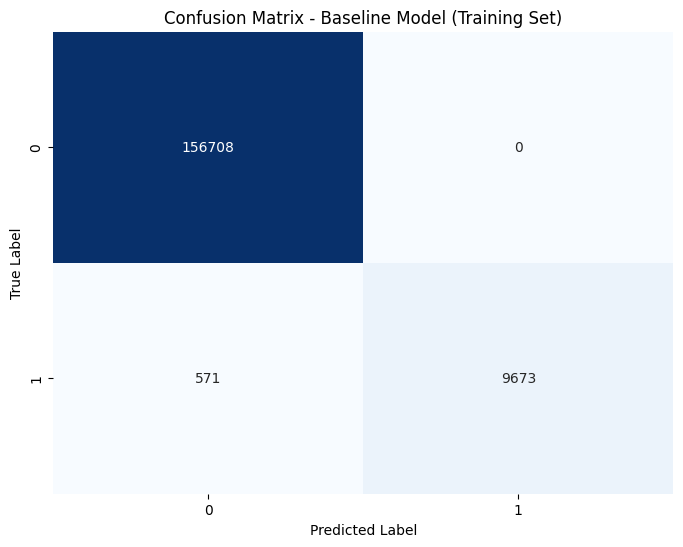

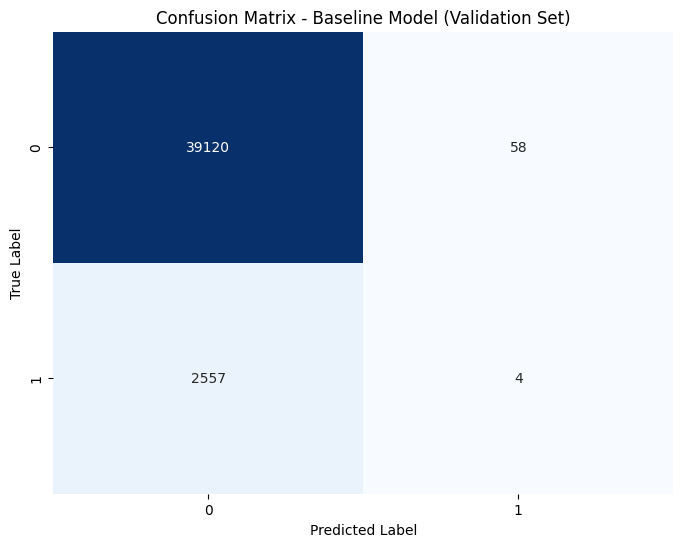


Baseline Model - Training vs. Validation Metrics:
               Metric  Training  Validation
0              AUC-PR  0.999998    0.077543
1  Weighted Precision  0.996592    0.885013
2              Recall  0.996580    0.937349
3            F1-Score  0.996534    0.908472
4   Balanced Accuracy  0.972130    0.500041


In [9]:
# Establish baseline model
base_params = {
    'n_estimators': 30,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}
baseline_model = RandomForestClassifier(**base_params)
baseline_model.fit(X_train_scaled, y_train)

# Evaluate on training set
y_train_pred_baseline = baseline_model.predict(X_train_scaled)
y_train_prob_baseline = baseline_model.predict_proba(X_train_scaled)[:, 1]

# Calculate training metrics
train_auc_pr = calculate_auc_pr(y_train, y_train_prob_baseline)
train_accuracy = balanced_accuracy_score(y_train, y_train_pred_baseline)
train_precision = precision_score(y_train, y_train_pred_baseline,average='weighted')
train_recall = recall_score(y_train, y_train_pred_baseline,average='weighted')
train_f1 = f1_score(y_train, y_train_pred_baseline,average='weighted')

# Plot confusion matrix for training set
cm_train = confusion_matrix(y_train, y_train_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Baseline Model (Training Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Evaluate on validation set
y_val_pred_baseline = baseline_model.predict(X_val_scaled)
y_val_prob_baseline = baseline_model.predict_proba(X_val_scaled)[:, 1]

# Calculate validation metrics
val_auc_pr = calculate_auc_pr(y_val, y_val_prob_baseline)
val_accuracy = balanced_accuracy_score(y_val, y_val_pred_baseline)
val_precision = precision_score(y_val, y_val_pred_baseline,average='weighted')
val_recall = recall_score(y_val, y_val_pred_baseline,average='weighted')
val_f1 = f1_score(y_val, y_val_pred_baseline,average='weighted')

# Plot confusion matrix for validation set
cm_val = confusion_matrix(y_val, y_val_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Baseline Model (Validation Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Compare metrics in a table
metrics_comparison = pd.DataFrame({
    'Metric': ['AUC-PR', 'Weighted Precision', 'Recall', 'F1-Score','Balanced Accuracy'],
    'Training': [train_auc_pr, train_precision, train_recall, train_f1,train_accuracy],
    'Validation': [val_auc_pr, val_precision, val_recall, val_f1,val_accuracy]
})

print("\nBaseline Model - Training vs. Validation Metrics:")
print(metrics_comparison)

## First Stage Grid Search for Parameter Selection


In [10]:
# Parameter Selection Analysis for Imbalanced Data
print("Starting parameter analysis...")

from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc

# Initialize lists to store results
param_names = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf','max_features']
param_values = {
    'n_estimators': [1, 10, 20, 30],
    'max_depth': [2, 5, 8, 15, None],
    'min_samples_split': [2, 10, 20, 35, 50],
    'min_samples_leaf': [1, 5, 10, 15, 30, 50],
    'max_features': ['sqrt', 'log2', None]
}

# Dictionary to store results - using global variables
global train_sensitivity_results, val_sensitivity_results
train_sensitivity_results = {}
val_sensitivity_results = {}

# Base model with default parameters
base_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': None,
    'random_state': 42
}

# Define stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Helper function to calculate AUC-PR
def calculate_auc_pr(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)

# For each parameter, vary its value while keeping others constant
print("Testing parameter sensitivities with cross-validation...")


for param_name in param_names:
    print(f"Analyzing parameter: {param_name}")
    train_param_scores = []
    val_param_scores = []

    for value in param_values[param_name]:
        # Create a copy of base parameters and update the current parameter
        current_params = base_params.copy()
        current_params[param_name] = value

        # Track scores across folds
        fold_train_scores = []
        fold_val_scores = []

        for train_idx, val_idx in skf.split(X_train_scaled, y_train):
            # Split data for this fold
            X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Train model with current parameters
            model = RandomForestClassifier(**current_params)
            model.fit(X_fold_train, y_fold_train)

            # Evaluate on training set
            y_fold_train_prob = model.predict_proba(X_fold_train)[:, 1]
            train_auc_pr = calculate_auc_pr(y_fold_train, y_fold_train_prob)
            fold_train_scores.append(train_auc_pr)

            # Evaluate on validation set
            y_fold_val_prob = model.predict_proba(X_fold_val)[:, 1]
            val_auc_pr = calculate_auc_pr(y_fold_val, y_fold_val_prob)
            fold_val_scores.append(val_auc_pr)

        # Calculate mean scores across folds
        mean_train_score = np.mean(fold_train_scores)
        mean_val_score = np.mean(fold_val_scores)

        # Store results
        train_param_scores.append((value, mean_train_score))
        val_param_scores.append((value, mean_val_score))

        print(f"  {param_name}={value}: Train={mean_train_score:.4f}, Val={mean_val_score:.4f}")

    # Store results for this parameter
    train_sensitivity_results[param_name] = train_param_scores
    val_sensitivity_results[param_name] = val_param_scores

# Verify that results were stored
print("\nResults stored successfully:")
print(f"Number of parameters analyzed: {len(train_sensitivity_results)}")
for param in train_sensitivity_results:
    print(f"  - {param}: {len(train_sensitivity_results[param])} values")

# To ensure the results persist, create a small verification dataframe
sensitivity_summary = pd.DataFrame({
    'Parameter': list(train_sensitivity_results.keys()),
    'Values_Tested': [len(train_sensitivity_results[p]) for p in train_sensitivity_results],
})
print("\nSensitivity Analysis Summary:")
print(sensitivity_summary)

print("Parameter sensitivity analysis completed!")

Starting parameter analysis...
Testing parameter sensitivities with cross-validation...
Analyzing parameter: n_estimators
  n_estimators=1: Train=0.6528, Val=0.1190
  n_estimators=10: Train=0.9971, Val=0.0778
  n_estimators=20: Train=1.0000, Val=0.0806
  n_estimators=30: Train=1.0000, Val=0.0822
Analyzing parameter: max_depth
  max_depth=2: Train=0.1072, Val=0.1041
  max_depth=5: Train=0.1325, Val=0.1056
  max_depth=8: Train=0.2260, Val=0.1047
  max_depth=15: Train=0.7401, Val=0.0979
  max_depth=None: Train=1.0000, Val=0.0861
Analyzing parameter: min_samples_split
  min_samples_split=2: Train=1.0000, Val=0.0861
  min_samples_split=10: Train=0.9982, Val=0.0918
  min_samples_split=20: Train=0.9681, Val=0.0946
  min_samples_split=35: Train=0.8836, Val=0.0967
  min_samples_split=50: Train=0.7886, Val=0.0978
Analyzing parameter: min_samples_leaf
  min_samples_leaf=1: Train=1.0000, Val=0.0861
  min_samples_leaf=5: Train=0.9595, Val=0.0950
  min_samples_leaf=10: Train=0.7637, Val=0.0998
  min

## Visualize AUC-PR Trend For Each Parameter


Analyzing coarse grid search results for parameters...

Found results for 5 parameters
Parameters to plot: ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']

Performance metrics for n_estimators:
Value      Training AUC-PR Validation AUC-PR Gap       
--------------------------------------------------
1          0.6528          0.1190          0.5338     *
10         0.9971          0.0778          0.9193    
20         1.0000          0.0806          0.9194    
30         1.0000          0.0822          0.9178    

Performance metrics for max_depth:
Value      Training AUC-PR Validation AUC-PR Gap       
--------------------------------------------------
2          0.1072          0.1041          0.0031    
5          0.1325          0.1056          0.0269     *
8          0.2260          0.1047          0.1213    
15         0.7401          0.0979          0.6423    
None       1.0000          0.0861          0.9139    

Performance metrics for m

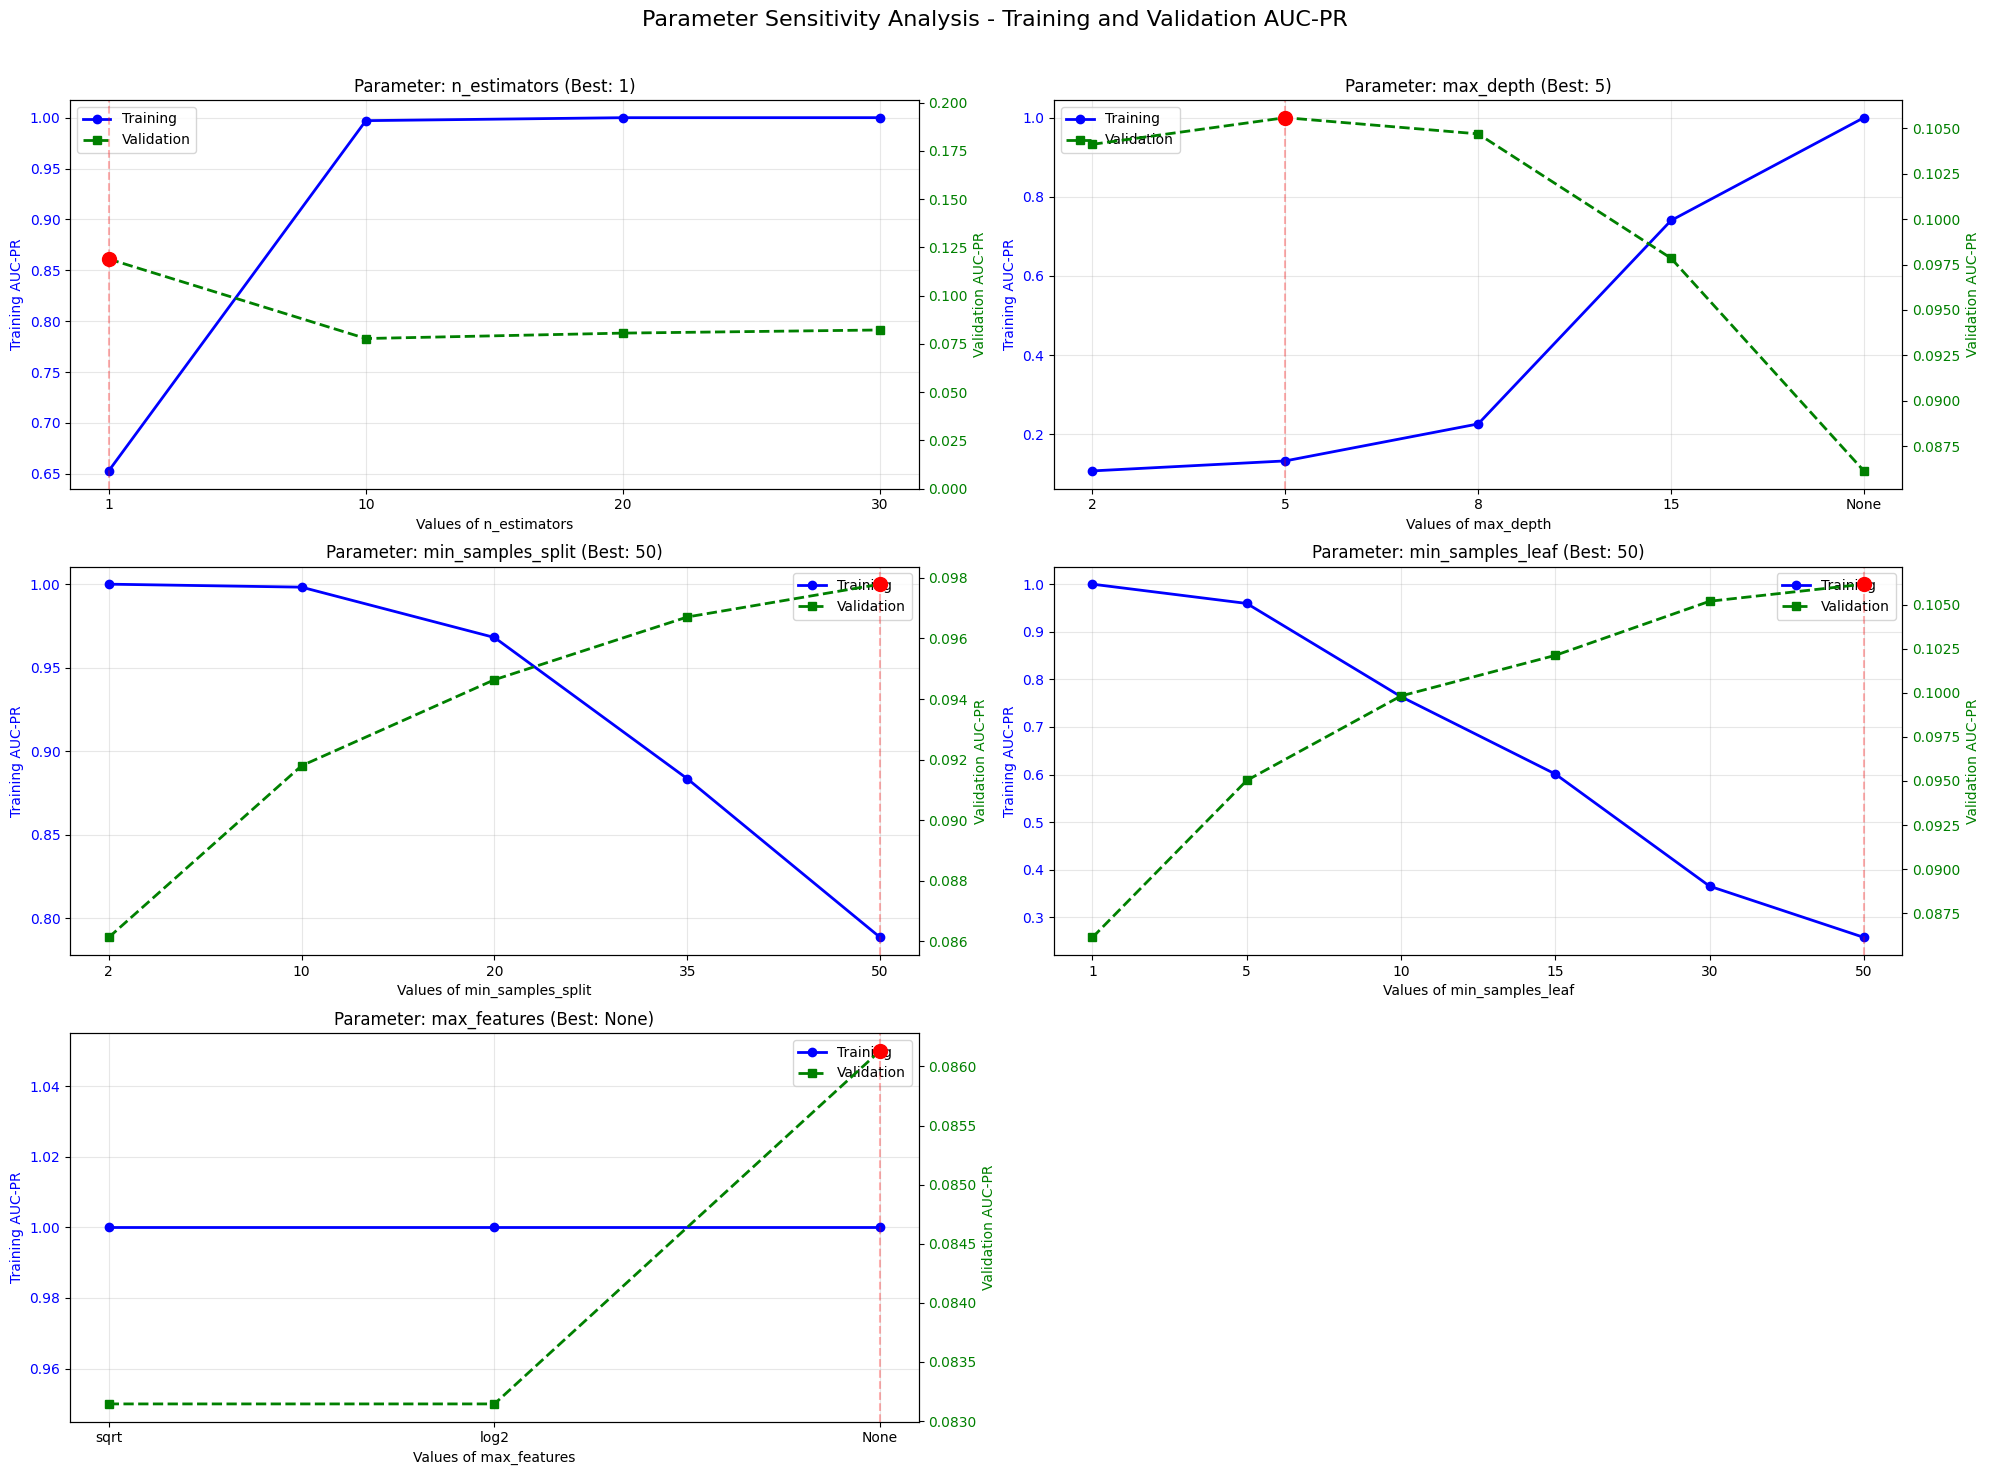

In [11]:
# Plot performance metrics for all parameters in one figure
print("\nAnalyzing coarse grid search results for parameters...\n")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Verify that results exist from previous cell
if 'train_sensitivity_results' not in globals() or 'val_sensitivity_results' not in globals():
    print("ERROR: Sensitivity results not found. Run the previous cell first.")
else:
    print(f"Found results for {len(train_sensitivity_results)} parameters")

    # Create a figure with 3x2 subplots
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Get parameters to plot - all parameters with results
    plot_params = list(train_sensitivity_results.keys())
    print(f"Parameters to plot: {plot_params}")

    # Loop through parameters and create visualizations in each subplot
    for i, param_name in enumerate(plot_params):
        if i >= len(axes):  # Safety check in case there are more parameters than subplots
            break

        # Get the parameter values and corresponding performance metrics
        param_values_list = [val for val, _ in train_sensitivity_results[param_name]]
        train_scores = [score for _, score in train_sensitivity_results[param_name]]
        val_scores = [score for _, score in val_sensitivity_results[param_name]]

        # Find the best value first
        best_idx = val_scores.index(max(val_scores))
        best_value = param_values_list[best_idx]
        best_score = val_scores[best_idx]

        # Convert param values to strings for plotting if they contain None
        x_values = range(len(param_values_list))
        x_labels = [str(v) for v in param_values_list]

        # Get the current subplot
        ax1 = axes[i]

        # Plot training scores on primary y-axis
        color = 'blue'
        ax1.set_xlabel(f'Values of {param_name}')
        ax1.set_ylabel('Training AUC-PR', color=color)
        ax1.plot(x_values, train_scores, 'o-', color=color, linewidth=2, label='Training')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xticks(x_values)
        ax1.set_xticklabels(x_labels)

        # Create secondary y-axis for validation scores
        ax2 = ax1.twinx()
        color = 'green'
        ax2.set_ylabel('Validation AUC-PR', color=color)
        ax2.plot(x_values, val_scores, 's--', color=color, linewidth=2, label='Validation')
        ax2.tick_params(axis='y', labelcolor=color)

        # For n_estimators, adjust the validation axis scale
        if param_name == 'n_estimators':
            val_min = min(val_scores)
            val_max = max(val_scores)
            val_range = val_max - val_min
            buffer = max(val_range * 2, 0.001)  # Ensure visible variations
            ax2.set_ylim([max(0, val_min - buffer), min(1, val_max + buffer)])

        # Mark the best value
        ax2.scatter([best_idx], [best_score], color='red', s=100, zorder=5)
        ax2.axvline(x=best_idx, color='red', linestyle='--', alpha=0.3)

        # Add a title for this subplot
        ax1.set_title(f'Parameter: {param_name} (Best: {best_value})')

        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

        # Add grid
        ax1.grid(True, alpha=0.3)

        # Output the detailed performance metrics for this parameter
        print(f"\nPerformance metrics for {param_name}:")
        print(f"{'Value':<10} {'Training AUC-PR':<15} {'Validation AUC-PR':<15} {'Gap':<10}")
        print("-" * 50)

        for val, train_score, val_score in zip(param_values_list, train_scores, val_scores):
            gap = train_score - val_score
            # Mark the best value with an asterisk
            best_mark = " *" if val == best_value else ""
            print(f"{str(val):<10} {train_score:<15.4f} {val_score:<15.4f} {gap:<10.4f}{best_mark}")

    # Hide the unused subplots
    for i in range(len(plot_params), len(axes)):
        axes[i].axis('off')

    # Add a main title for the entire figure
    plt.suptitle('Parameter Sensitivity Analysis - Training and Validation AUC-PR', fontsize=16)

    # Adjust spacing between subplots
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle

    # Show the combined figure
    plt.show()


## Fine-grained Grid Search For Optimal Value of n_estimators

Starting fine-grained grid search with robust AUC-PR scorer
y_train distribution: label
0    156708
1     10244
Name: count, dtype: int64
Running direct cross-validation for each parameter combination...
Params: leaf=8, split=10 - Mean AUC-PR: 0.1316, Fold scores: [0.11200391891639293, 0.09765424936363337, 0.11700454377545474, 0.09229438019531418, 0.1270595904991243, 0.10409509303523132, 0.11410134204886305, 0.15174457141828626, 0.17048348786331435, 0.1615833686196735, 0.16431025816746547, 0.13727129651717668, 0.1659995368077356, 0.15582087917188225, 0.1606942047475679, 0.14360109088777567, 0.17280931503029676, 0.14385056606174929, 0.1580263758534707, 0.10667896789603218, 0.12502662880449927, 0.17128623193478798, 0.10029823919731554, 0.12865348865026283, 0.13768731406270535, 0.1255667023348501, 0.15008357984529352, 0.13716752251779865, 0.17916163690278605, 0.14853658959601898, 0.09464160888497994, 0.15975906670984422, 0.1436590863640203, 0.15834802899422945, 0.09378330791685252, 0.1119

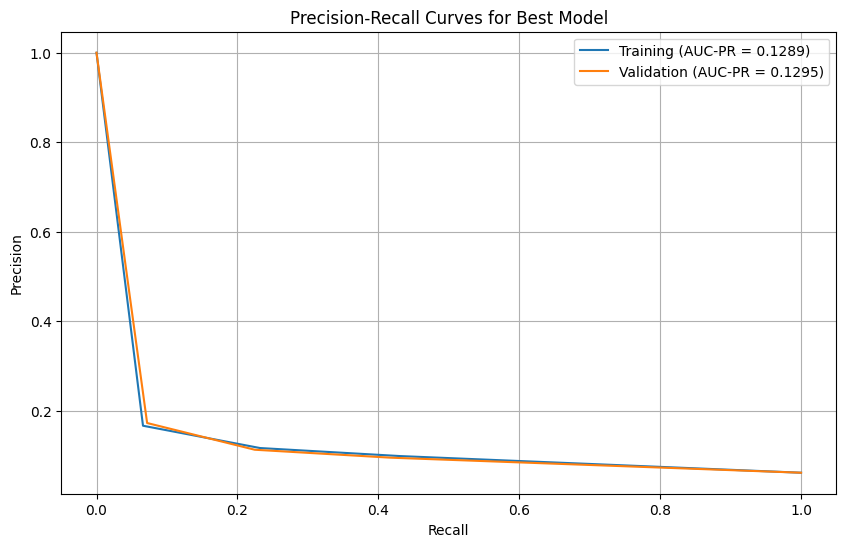

In [17]:
# Fine-Grained Grid Search for Random Forest with more robust AUC-PR scoring
print("Starting fine-grained grid search with robust AUC-PR scorer")

from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import make_scorer
import warnings

# Define a more robust AUC-PR scorer function with detailed error handling
def auc_pr_score(y_true, y_prob):
    try:
        # Check for problematic conditions
        if len(np.unique(y_true)) < 2:
            warnings.warn(f"Only one class present in y_true. Returning 0.0")
            return 0.0

        # Some models might predict only one class
        if len(np.unique(y_prob)) < 2:
            warnings.warn(f"Constant probabilities detected. Returning 0.0")
            return 0.0

        precision, recall, _ = precision_recall_curve(y_true, y_prob)

        # Calculate AUC with additional safeguards
        if len(precision) > 1 and len(recall) > 1:
            return auc(recall, precision)
        else:
            warnings.warn("Insufficient points for AUC calculation. Returning 0.0")
            return 0.0
    except Exception as e:
        warnings.warn(f"Error in AUC-PR calculation: {e}. Returning 0.0")
        return 0.0

# Create a custom scorer with debugging
auc_pr_scorer = make_scorer(auc_pr_score, needs_proba=True, greater_is_better=True)

# Define a more refined parameter grid
fine_param_grid = {
    'max_depth': [2],
    'min_samples_leaf': [8,9,10,11,12],
    'min_samples_split': [10,12,14,16,18,20,22,24,26,28,30],
    'n_estimators': [1],
    'max_features': [None],
    'random_state': [42]
}

# Run diagnostics on your data
print(f"y_train distribution: {y_train.value_counts()}")

# Let's try a direct cross-validation approach instead of GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

# Initialize results dictionary
cv_results = {}

# Stratified K-Fold to maintain class balance
cv = StratifiedKFold(n_splits=100, shuffle=True, random_state=42)

print("Running direct cross-validation for each parameter combination...")
best_score = 0
best_params = None

# Iterate through parameter combinations
for min_samples_leaf in fine_param_grid['min_samples_leaf']:
    for min_samples_split in fine_param_grid['min_samples_split']:
        params = {
            'max_depth': 2,
            'min_samples_leaf': min_samples_leaf,
            'min_samples_split': min_samples_split,
            'n_estimators': 1,
            'max_features': None,
            'random_state': 42
        }

        # Create model with these parameters
        model = RandomForestClassifier(**params)

        # Manual cross-validation with AUC-PR scoring
        fold_scores = []
        for train_idx, val_idx in cv.split(X_train_scaled,y_train):
            # Split data
            X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Train model
            model.fit(X_cv_train, y_cv_train)

            # Get probabilities
            y_cv_val_prob = model.predict_proba(X_cv_val)[:, 1]

            # Calculate AUC-PR manually
            try:
                precision, recall, _ = precision_recall_curve(y_cv_val, y_cv_val_prob)
                fold_auc_pr = auc(recall, precision)
                fold_scores.append(fold_auc_pr)
            except Exception as e:
                print(f"Error in fold for params {params}: {e}")
                fold_scores.append(0.0)

        # Average score across folds
        mean_score = np.mean(fold_scores)

        # Store result
        param_key = f"leaf={min_samples_leaf}, split={min_samples_split}"
        cv_results[param_key] = {
            'params': params,
            'mean_score': mean_score,
            'fold_scores': fold_scores
        }

        print(f"Params: {param_key} - Mean AUC-PR: {mean_score:.4f}, Fold scores: {fold_scores}")

        # Update best parameters
        if mean_score > best_score:
            best_score = mean_score
            best_params = params

# Print best results
print(f"\nBest parameters: {best_params}")
print(f"Best AUC-PR score: {best_score:.4f}")

# Create best model for final evaluation
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

# Evaluate on training set
y_train_prob = best_model.predict_proba(X_train_scaled)[:, 1]
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_prob)
train_auc_pr = auc(train_recall, train_precision)

# Evaluate on validation set
y_val_prob = best_model.predict_proba(X_val_scaled)[:, 1]
val_precision, val_recall, _ = precision_recall_curve(y_val, y_val_prob)
val_auc_pr = auc(val_recall, val_precision)

print(f"\nBest Model Evaluation:")
print(f"Training AUC-PR: {train_auc_pr:.4f}")
print(f"Validation AUC-PR: {val_auc_pr:.4f}")

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
plt.plot(train_recall, train_precision, label=f'Training (AUC-PR = {train_auc_pr:.4f})')
plt.plot(val_recall, val_precision, label=f'Validation (AUC-PR = {val_auc_pr:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Best Model')
plt.legend()
plt.grid(True)
plt.show()

## Visualize Fine-grained Grid Search Result

Comparing baseline model and best fine-tuned model...

Baseline model - Validation AUC-PR: 0.0807
Best fine-tuned model - Validation AUC-PR: 0.1295
Absolute improvement: 0.0488
Percentage improvement: 60.52%


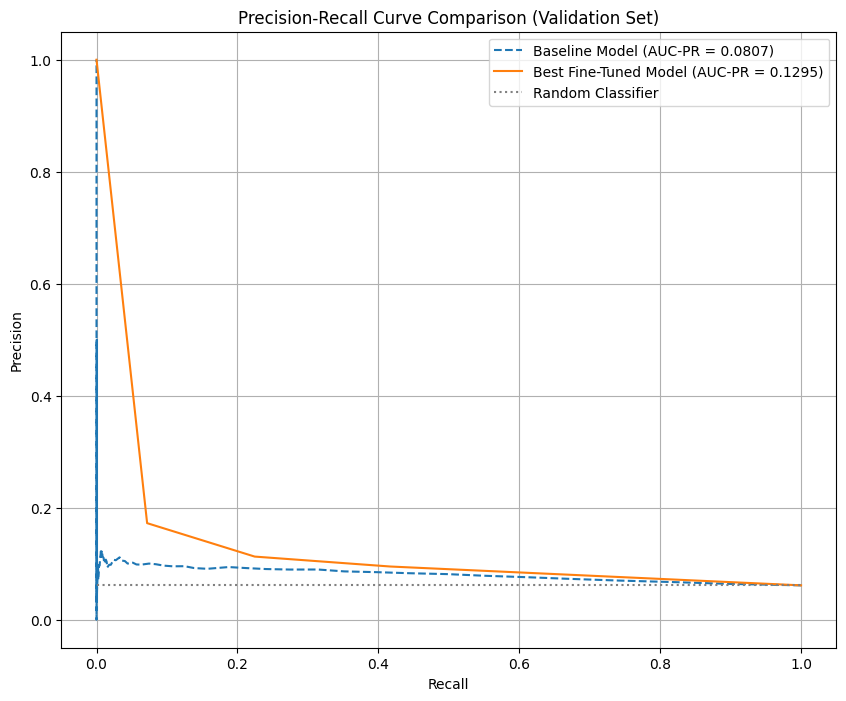


==== Model Parameters ====
Best Fine-Tuned Model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 1, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [18]:
# Compare baseline model vs best fine-tuned model - focused on AUC-PR
print("Comparing baseline model and best fine-tuned model...")

# Import necessary metrics
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Define the baseline model (using default parameters)
baseline_model = RandomForestClassifier(random_state=42)
baseline_model.fit(X_train_scaled, y_train)

# Define the best fine-tuned model (already trained above)
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train_scaled, y_train)

# Calculate PR curves and AUC-PR values
# Baseline model
y_train_prob_baseline = baseline_model.predict_proba(X_train_scaled)[:, 1]
y_val_prob_baseline = baseline_model.predict_proba(X_val_scaled)[:, 1]

train_precision_baseline, train_recall_baseline, _ = precision_recall_curve(y_train, y_train_prob_baseline)
train_auc_pr_baseline = auc(train_recall_baseline, train_precision_baseline)

val_precision_baseline, val_recall_baseline, _ = precision_recall_curve(y_val, y_val_prob_baseline)
val_auc_pr_baseline = auc(val_recall_baseline, val_precision_baseline)

# Best model
y_train_prob_best = best_model.predict_proba(X_train_scaled)[:, 1]
y_val_prob_best = best_model.predict_proba(X_val_scaled)[:, 1]

train_precision_best, train_recall_best, _ = precision_recall_curve(y_train, y_train_prob_best)
train_auc_pr_best = auc(train_recall_best, train_precision_best)

val_precision_best, val_recall_best, _ = precision_recall_curve(y_val, y_val_prob_best)
val_auc_pr_best = auc(val_recall_best, val_precision_best)

# Calculate improvement percentage
improvement_absolute = val_auc_pr_best - val_auc_pr_baseline
improvement_percentage = (improvement_absolute / val_auc_pr_baseline) * 100

# Print AUC-PR values and improvement
print(f"\nBaseline model - Validation AUC-PR: {val_auc_pr_baseline:.4f}")
print(f"Best fine-tuned model - Validation AUC-PR: {val_auc_pr_best:.4f}")
print(f"Absolute improvement: {improvement_absolute:.4f}")
print(f"Percentage improvement: {improvement_percentage:.2f}%")

# Plot Precision-Recall curves for both models (validation set)
plt.figure(figsize=(10, 8))

# Plot PR curves
plt.plot(val_recall_baseline, val_precision_baseline,
         label=f'Baseline Model (AUC-PR = {val_auc_pr_baseline:.4f})',
         linestyle='--')
plt.plot(val_recall_best, val_precision_best,
         label=f'Best Fine-Tuned Model (AUC-PR = {val_auc_pr_best:.4f})')

# Add reference line for random classifier
plt.plot([0, 1], [y_val.mean(), y_val.mean()],
         linestyle=':', color='gray', label='Random Classifier')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

# Print model parameters
print("\n==== Model Parameters ====")
print(f"Best Fine-Tuned Model: {best_model.get_params()}")

Finding optimal threshold using combined training and validation sets...
Combined dataset shape: X=(208691, 12), y=(208691,)
Combined dataset metrics (default threshold 0.5):
AUC-PR: 0.1552
Accuracy: 0.9386
Weighted Precision: 0.8810
Weighted Recall: 0.9386
Weighted F1 Score: 0.9089

Finding optimal threshold based on weighted F1 score...


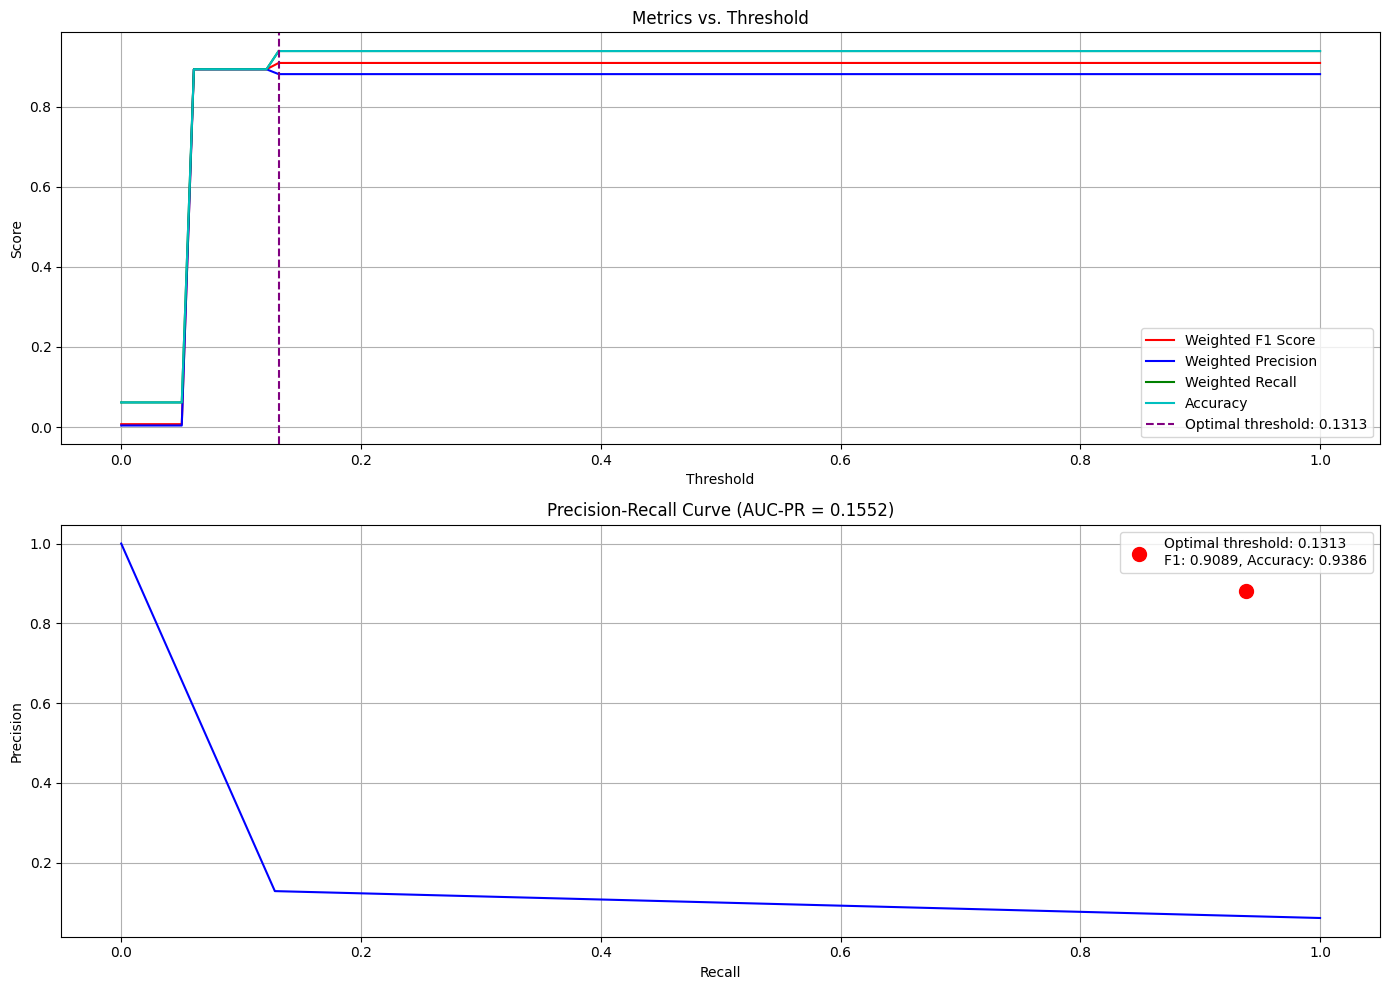


Evaluating model on test set using optimal threshold...

==== Training vs Test Performance Comparison ====
               Metric  Combined Training  Test Set  Difference
0              AUC-PR             0.1552    0.1572      0.0020
1   Weighted F1 Score             0.9089    0.9105      0.0015
2  Weighted Precision             0.8810    0.8830      0.0020
3     Weighted Recall             0.9386    0.9397      0.0010
4            Accuracy             0.9386    0.9397      0.0010


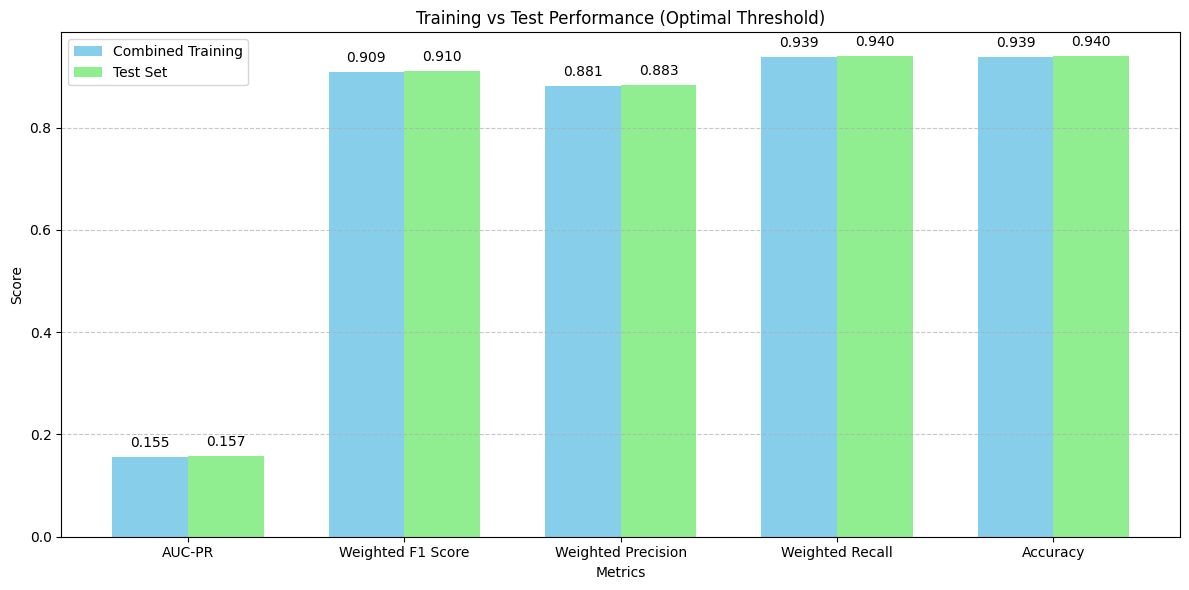


======= Final Model Summary =======
Best hyperparameters:
  max_depth: 1
  min_samples_leaf: 4
  min_samples_split: 10
  n_estimators: 1
  random_state: 42
Optimal threshold: 0.1313
Test set AUC-PR: 0.1572
Test set Accuracy: 0.9397
Test set Weighted F1-Score: 0.9105

Adding predictions to original test data and exporting to CSV...
Exported predictions to test_with_predictions.csv

Sample of test data with predictions:
   user_id  merchant_id  label  age_range  gender  ...  shopping_carts  \
0   399620          310      0     3.0000  1.0000  ...               0   
1   183656         3129      0     2.0000  1.0000  ...               0   
2   214005         3609      0     2.0000  0.0000  ...               0   
3    76778         2824      0     3.0000  1.0000  ...               0   
4   258043         4760      1     4.0000  0.0000  ...               0   

   purchase_times  favourite_times  predicted_probability  predicted_label  
0               1                0                 0.05

In [19]:
# Train model using the best parameters on combined training + validation data
print("Finding optimal threshold using combined training and validation sets...")

# Import necessary metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np

# Combine training and validation sets
X_combined = np.vstack((X_train_scaled, X_val_scaled))
y_combined = pd.concat([y_train, y_val])

print(f"Combined dataset shape: X={X_combined.shape}, y={y_combined.shape}")

# Define best parameters
best_params = {
    'max_depth': 1,
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 1,
    'random_state': 42
}

# Train model on combined dataset
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_combined, y_combined)

# Get probability predictions
y_combined_prob = best_model.predict_proba(X_combined)[:, 1]
y_combined_pred = best_model.predict(X_combined)  # Default threshold (0.5)

# Calculate AUC-PR and accuracy on combined dataset
combined_precision, combined_recall, _ = precision_recall_curve(y_combined, y_combined_prob)
combined_auc_pr = auc(combined_recall, combined_precision)
combined_accuracy = accuracy_score(y_combined, y_combined_pred)
combined_weighted_precision = precision_score(y_combined, y_combined_pred, average='weighted')
combined_weighted_recall = recall_score(y_combined, y_combined_pred, average='weighted')
combined_weighted_f1 = f1_score(y_combined, y_combined_pred, average='weighted')

print(f"Combined dataset metrics (default threshold 0.5):")
print(f"AUC-PR: {combined_auc_pr:.4f}")
print(f"Accuracy: {combined_accuracy:.4f}")
print(f"Weighted Precision: {combined_weighted_precision:.4f}")
print(f"Weighted Recall: {combined_weighted_recall:.4f}")
print(f"Weighted F1 Score: {combined_weighted_f1:.4f}")

# Find optimal threshold by testing different thresholds and calculating weighted F1 score
print("\nFinding optimal threshold based on weighted F1 score...")

# Get thresholds from precision-recall curve
thresholds = np.linspace(0, 1, 100)  # Test 100 thresholds from 0 to 1
best_threshold = 0.5  # Default threshold
best_f1 = 0

# Calculate metrics at different thresholds
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

for threshold in thresholds:
    # Convert probabilities to binary predictions using current threshold
    y_pred = (y_combined_prob >= threshold).astype(int)

    # Calculate weighted precision, recall, F1 score, and accuracy
    prec = precision_score(y_combined, y_pred, average='weighted')
    rec = recall_score(y_combined, y_pred, average='weighted')
    acc = accuracy_score(y_combined, y_pred)

    # Calculate F1 score (using directly weighted F1)
    f1 = f1_score(y_combined, y_pred, average='weighted')

    # Store scores
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)
    accuracy_scores.append(acc)

    # Update best threshold if this F1 score is better
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Get scores at the best threshold
best_idx = np.argmin(np.abs(thresholds - best_threshold))
best_precision = precision_scores[best_idx]
best_recall = recall_scores[best_idx]
best_accuracy = accuracy_scores[best_idx]

# Create visualizations
plt.figure(figsize=(14, 10))

# Create subplot for threshold vs. metrics
plt.subplot(2, 1, 1)
plt.plot(thresholds, f1_scores, 'r-', label='Weighted F1 Score')
plt.plot(thresholds, precision_scores, 'b-', label='Weighted Precision')
plt.plot(thresholds, recall_scores, 'g-', label='Weighted Recall')
plt.plot(thresholds, accuracy_scores, 'c-', label='Accuracy')
plt.axvline(x=best_threshold, color='purple', linestyle='--', label=f'Optimal threshold: {best_threshold:.4f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Threshold')
plt.legend()
plt.grid(True)

# Create subplot for precision-recall curve
plt.subplot(2, 1, 2)
plt.plot(combined_recall, combined_precision, 'b-')
plt.scatter([best_recall], [best_precision], color='red', s=100,
           label=f'Optimal threshold: {best_threshold:.4f}\nF1: {best_f1:.4f}, Accuracy: {best_accuracy:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC-PR = {combined_auc_pr:.4f})')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

y_test=test_data['label']

# Evaluate model on test set using optimal threshold
print("\nEvaluating model on test set using optimal threshold...")
y_test_prob = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_prob >= best_threshold).astype(int)
y_test_pred_default = best_model.predict(X_test_scaled)  # Default threshold (0.5)

# Calculate test metrics with optimal threshold
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate test metrics with default threshold
test_accuracy_default = accuracy_score(y_test, y_test_pred_default)
test_f1_default = f1_score(y_test, y_test_pred_default, average='weighted')

# Calculate AUC-PR on test set
test_precision_curve, test_recall_curve, _ = precision_recall_curve(y_test, y_test_prob)
test_auc_pr = auc(test_recall_curve, test_precision_curve)


# Create a comparison table for train vs test performance
comparison_data = {
    'Metric': ['AUC-PR', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall', 'Accuracy'],
    'Combined Training': [combined_auc_pr, best_f1, best_precision, best_recall, best_accuracy],
    'Test Set': [test_auc_pr, test_f1, test_precision, test_recall, test_accuracy],
    'Difference': [test_auc_pr - combined_auc_pr,
                   test_f1 - best_f1,
                   test_precision - best_precision,
                   test_recall - best_recall,
                   test_accuracy - best_accuracy]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n==== Training vs Test Performance Comparison ====")
pd.set_option('display.float_format', '{:.4f}'.format)
print(comparison_df)

# Plot performance comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(comparison_data['Metric']))
width = 0.35

plt.bar(x - width/2, comparison_data['Combined Training'], width, label='Combined Training', color='skyblue')
plt.bar(x + width/2, comparison_data['Test Set'], width, label='Test Set', color='lightgreen')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Training vs Test Performance (Optimal Threshold)')
plt.xticks(x, comparison_data['Metric'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for i, v in enumerate(comparison_data['Combined Training']):
    plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')

for i, v in enumerate(comparison_data['Test Set']):
    plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Final model summary
print("\n======= Final Model Summary =======")
print("Best hyperparameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"Optimal threshold: {best_threshold:.4f}")
print(f"Test set AUC-PR: {test_auc_pr:.4f}")
print(f"Test set Accuracy: {test_accuracy:.4f}")
print(f"Test set Weighted F1-Score: {test_f1:.4f}")

# ======================================================================
# Add predictions to the original test data and export to CSV
# ======================================================================

print("\nAdding predictions to original test data and exporting to CSV...")


try:
    original_test_df = test_data.copy()
except NameError:
    print("Original test dataframe not found. Please ensure test_df is defined or load from file.")

# Add prediction columns to the original test dataframe
original_test_df['predicted_probability'] = y_test_prob
original_test_df['predicted_label'] = y_test_pred  # Using optimal threshold

# Export the augmented test data to CSV
output_filename = 'test_with_predictions.csv'
original_test_df.to_csv(output_filename, index=False)
print(f"Exported predictions to {output_filename}")

# Display a sample of the predictions
print("\nSample of test data with predictions:")
pd.set_option('display.max_columns', 10)
print(original_test_df.head())